# EnKF with perturbed observations
This notebook executes a perturbed observation EnKF using Lorenz-96 dynamics

Lorenz-96 is a system of ODEs the evolve according to 

$$
\frac{dx_i}{dt} = (x_{i+1}-x_{i-1})x_{i-1}-x_i + F
$$

where we assume periodicity $x_{-1} = x_{N-1}, x_0 = x_N, x_{N+1} = x_1$. Setting F = 8 leads to chaotic behavior

In [7]:
# Import necessary packages
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import matplotlib.pyplot as plt

In [14]:
# Define the system of ODEs
def L96(x, t):
    return (np.roll(x, -1)-np.roll(x,2))*np.roll(x,1)-x+F

In [15]:
# Perturbed Observation EnKF
# Inputs: Forecast, X; Observations, y; Localization matrix, L; Observation std, sigma
def EnKF(X, y, L, sigma):
    Xmean = np.mean(X,0)                                   # Ensemble mean
    A = 1/np.sqrt(Ne-1)*(X-Xmean)                          # Deviation from the mean
    V = A                                                  # Observe all variables
    R = sigma**2*np.eye(np.shape(A)[1])                    # Observation variance
    Khat = (A.T@V)@np.linalg.inv(V.T@V+R)
    Khat = Khat*L                                          # Localization
    E = sigma * rng.normal(size = np.shape(A))             # Perturbed observation
    for i in range(np.shape(X)[0]):
        X[i] = X[i]+Khat@(y - X[i]-E[i])
    return X

In [16]:
# Set up the model
K = 40   # Number of variables
F = 8    # Forcing in Lorenz-96
Ne = 40  # Ensemble members
t_final = 6 # Model run time
dt = 0.1   # Model time steps
rng = np.random.default_rng(seed = 42)   # Random number generator seed for reproducibility

In [17]:
# Compute True Solutions
x0 = rng.normal(0,1,size = K)
t = np.arange(0,t_final,dt)
x_true = odeint(L96, x0, t) # rows are time and columns are variables

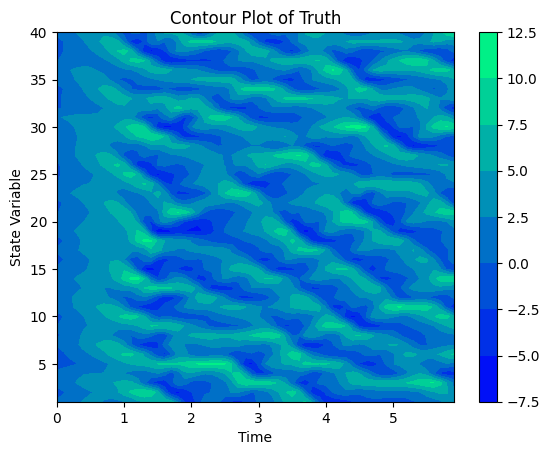

In [18]:
# Plot the state variables in time in a contour plot
z = np.arange(1,K+1, 1)
T,Z = np.meshgrid(t,z)
plt.figure()
contourf = plt.contourf(T,Z,x_true.T, cmap = 'winter')
plt.colorbar(contourf)
plt.title('Contour Plot of Truth')
plt.xlabel('Time')
plt.ylabel('State Variable')

Text(0, 0.5, 'State Variable')

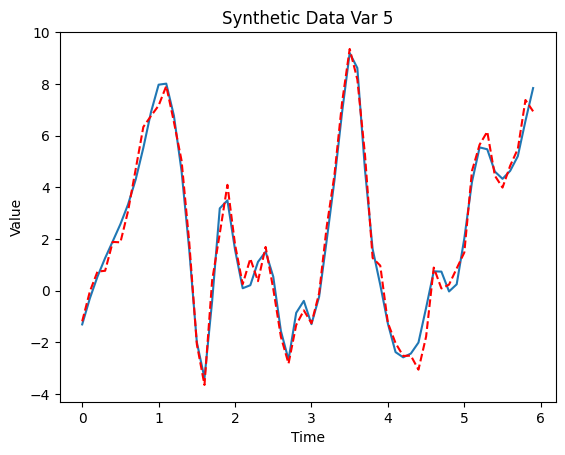

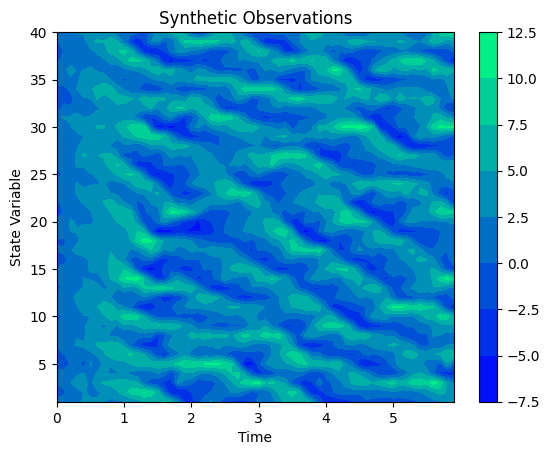

In [19]:
# Synthetic observations
RMS = np.sqrt(np.mean(x_true,0)**2)  # Time RMS
sigma = 0.25*RMS
R = sigma**2*np.eye(K)
y = x_true +sigma*rng.normal(size = np.shape(x_true))

plt.figure()
var = 5
plt.plot(t,x_true[:,var])
plt.plot(t,y[:,var],'--', color = 'red')
plt.title('Synthetic Data Var ' + str(var))
plt.xlabel('Time')
plt.ylabel('Value')

# Plot the state variables in time in a contour plot
z = np.arange(1,K+1, 1)
T,Z = np.meshgrid(t,z)
plt.figure()
contourf = plt.contourf(T,Z,y.T, cmap = 'winter')
plt.colorbar(contourf)
plt.title('Synthetic Observations')
plt.xlabel('Time')
plt.ylabel('State Variable')

Dynamics took 5.472834825515747 seconds


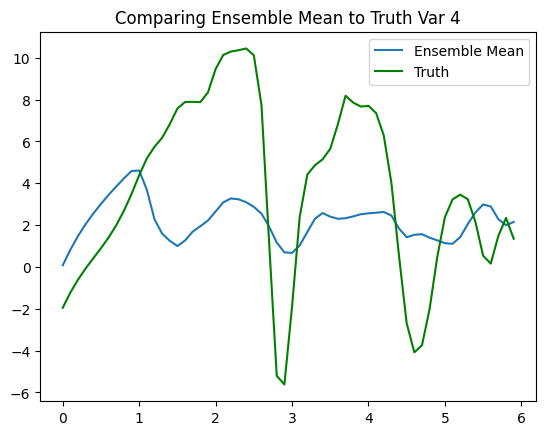

In [20]:
# Run the dynamics and keep the values
X_free = np.zeros([np.size(t),Ne,K]) # Dimensions: time, ensemble member, variables
X_free[0] = rng.normal(size = [Ne, K]) 
start = time.time()
for j in range(np.size(t)-1):
    for i in range(Ne):
        X_free[j+1,i] = odeint(L96, X_free[j,i], t[0:2])[1]
end = time.time()
total = end-start
print('Dynamics took ' +str(total)+ ' seconds')

# Compare to truth
var = 4
plt.figure()
plt.plot(t, np.mean(X_free,1)[:,var])
plt.plot(t, x_true[:,var],color = 'green')
plt.title('Comparing Ensemble Mean to Truth Var ' +str(var))
plt.legend(['Ensemble Mean', 'Truth'])

In [21]:
# Assimilation freqency
af = 3   # Number of time steps before assimilation
ta = np.arange(af*dt,t_final,af*dt)

# Initial state
X = np.zeros([np.size(t),Ne,K]) # Dimensions: time, ensemble member, variables
X[0] = rng.normal(size = [Ne, K]) 

Xfor = np.zeros([np.size(t),Ne,K])
Xfor[0] = X[0]

# Localization
L =  np.eye(K)
L1 = np.eye(K, k = 1)
L2 = np.eye(K, k = -1)
L = L+L1+L2

# Advance in time
for j in range(np.size(t)-1):
    # Dynamics
    for i in range(Ne):
        X[j+1,i] = odeint(L96, X[j,i], t[0:2])[1]
    Xfor[j+1,:] = X[j+1,:]
    
    # EnKF Assimilation
    if (j+1)%af == 0:
        time = t[j+1]
        print('Assimilating at t = ' + str(time))
        X[j+1,:,:] = EnKF(X[j+1,:,:], y[j+1], L, sigma)


Assimilating at t = 0.30000000000000004
Assimilating at t = 0.6000000000000001
Assimilating at t = 0.9
Assimilating at t = 1.2000000000000002
Assimilating at t = 1.5
Assimilating at t = 1.8
Assimilating at t = 2.1
Assimilating at t = 2.4000000000000004
Assimilating at t = 2.7
Assimilating at t = 3.0
Assimilating at t = 3.3000000000000003
Assimilating at t = 3.6
Assimilating at t = 3.9000000000000004
Assimilating at t = 4.2
Assimilating at t = 4.5
Assimilating at t = 4.800000000000001
Assimilating at t = 5.1000000000000005
Assimilating at t = 5.4
Assimilating at t = 5.7


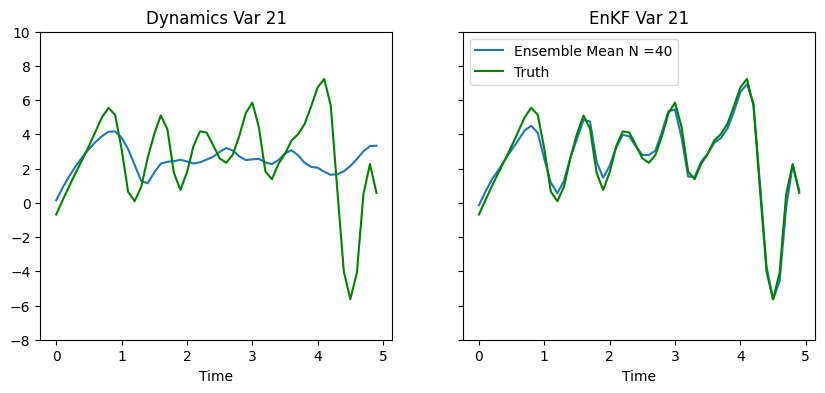

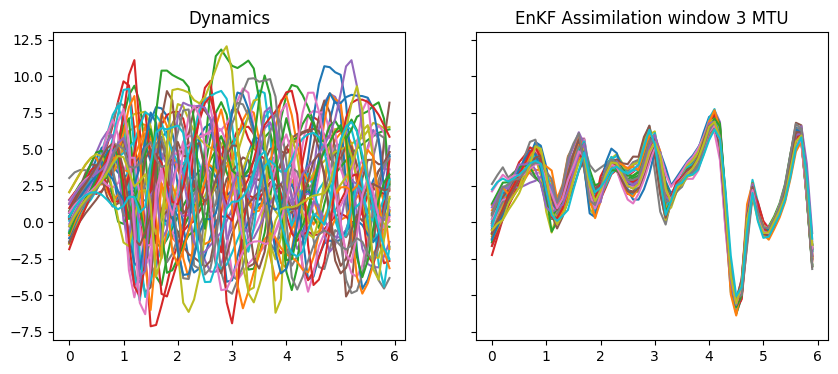

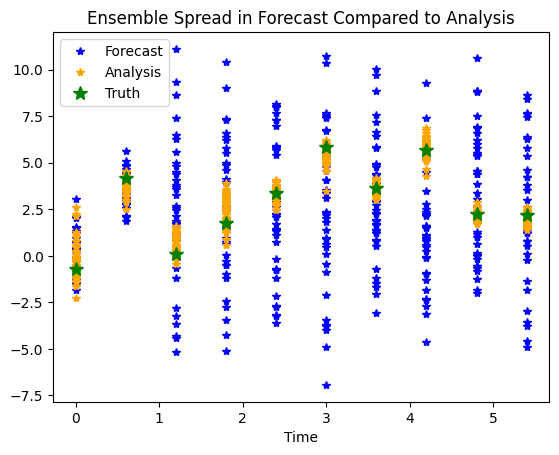

In [37]:
# Results for a single variable
var = 21   # Choose a variable you want to explore

# Compare ensemble mean to truth for all time
fig, axs = plt.subplots(1,2, sharey= True, figsize = (10,4))
# Dynamics- no assimilation
axs[0].plot(t[0:50], np.mean(X_free,1)[0:50,var])
axs[0].plot(t[0:50], x_true[0:50,var],color = 'green')
axs[0].set_title('Dynamics Var ' +str(var))
axs[0].set_xlabel('Time')
# EnKF
axs[1].plot(t[0:50], np.mean(X,1)[0:50,var])
axs[1].plot(t[0:50], x_true[0:50,var],color = 'green')
axs[1].set_title('EnKF Var ' +str(var))
axs[1].legend(['Ensemble Mean N =' + str(Ne), 'Truth'])
axs[1].set_xlabel('Time')
axs[1].set_ylim([-8,10])

# Visualize Ensemble Spread across time
fig, axs = plt.subplots(1,2, sharey= True, figsize = (10,4))
# Dynamics
axs[0].plot(t,X_free[:,:,var])
axs[0].set_title('Dynamics')
# EnKF
axs[1].plot(t,X[:,:,var])
axs[1].set_title('EnKF Assimilation window '+str(af) + ' MTU')

# Visualize ensemble spread for a given day
x = np.ones(Ne)
plt.figure()
for i in range(10):
    d1 = af*(i*2)
    plt.plot(x*t[d1],X_free[d1,:,var], '*', color = 'blue')
    plt.plot(x*t[d1],X[d1,:,var], '*', color = 'orange')
    plt.plot(t[d1],x_true[d1,var], '*', color = 'green', markersize = 10)
plt.title('Ensemble Spread in Forecast Compared to Analysis')
plt.xlabel('Time')
plt.legend(['Forecast', 'Analysis', 'Truth'])

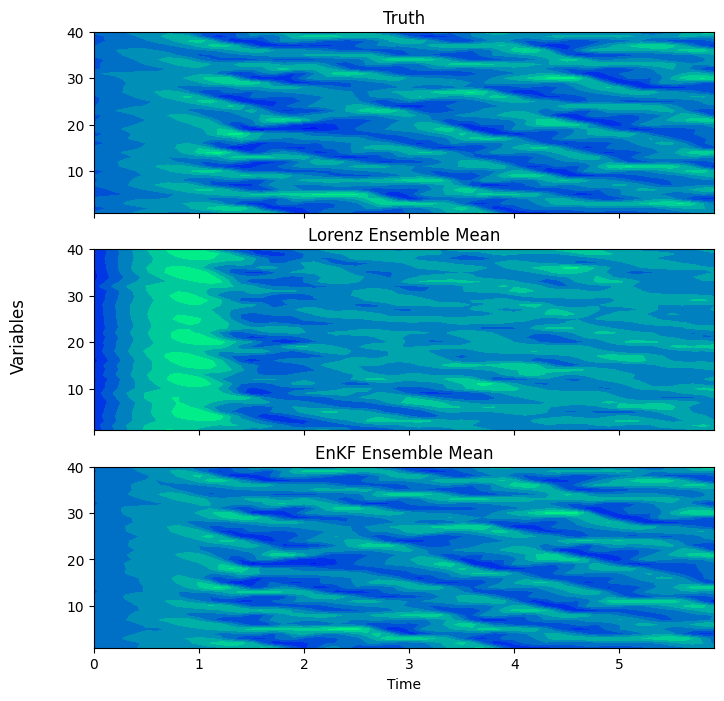

In [38]:
# Contour Plots
# No assimilation
fig, ax = plt.subplots(3,1, sharex = True)
cbar = ax[0].contourf(T,Z, x_true.T, cmap = 'winter')
ax[0].set_title('Truth')
ax[1].contourf(T,Z,np.mean(X_free,1).T, cmap = 'winter')
ax[1].set_title('Lorenz Ensemble Mean')
ax[2].contourf(T,Z, np.mean(X,1).T, cmap = 'winter')
ax[2].set_title('EnKF Ensemble Mean')
ax[2].set_xlabel('Time')
fig.supylabel('Variables')

# Change the figure size after creation
fig.set_figwidth(8)  # Set width to 8 inches
fig.set_figheight(8) # Set height to 4 inches